# Module Imports

In [6]:
from tqdm.notebook import tqdm as tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import methylprep
import methylcheck
from scipy import stats
from sklearn.metrics import mean_squared_error
sns.set_style('darkgrid')

# Load Data from SeSAMe 

In [2]:
# load and format predicted ages
r_ages = pd.read_csv('../data/input/r_ages.csv')
r_ages = r_ages.rename(columns={'Unnamed: 0' : 'lab_id'})
r_ages = r_ages.rename(columns={'x' : 'predicted_age'})

# load and format sample data
sample_data = pd.read_csv('../data/output/formatted_metadata.csv')
sample_data = sample_data.drop(columns=['Sample_Type'])

# add predicted ages to sample data
sample_data = sample_data.merge(r_ages, how='left', on='lab_id')
sample_data.head()

,sample_id,tissue,lab_id,predicted_age
0,211,Kidney,204450040037_R01C02,8.058126
1,211,Liver,204450040017_R01C02,14.008716
2,211,Heart,204450040037_R01C01,10.230413
3,211,L Gastroc,204450040017_R01C01,14.072019
4,218,Kidney,204450040008_R01C02,7.916990


In [3]:
# load and format metadata
metadata = pd.read_excel('../data/input/Chen Main Database - May 2021.xlsx')
metadata["MouseID"] = metadata.MouseID.str.replace('Chen', '')
metadata["MouseID"] = metadata["MouseID"].astype('int64')
metadata = metadata.rename(columns={'MouseID' : 'sample_id'})
metadata['age'] = (metadata['DOD'] - metadata['DOB']) / np.timedelta64(1, 'M')
metadata = metadata.replace({'F': 'Female', 'M': 'Male'})
metadata.head()

,Cage,sample_id,Color,EarNotch,Sex,DOB,DOW,DOD,DeathWeight,Comments,age
0,1,1,AG,N,Female,2019-07-19,2019-08-08,2021-05-20,35.1,NaN,22.045627
1,1,8,BAG,R,Female,2019-07-19,2019-08-08,2021-05-20,40.3,NaN,22.045627
2,1,15,BLK,N,Female,2019-07-13,2019-08-02,2021-05-20,31.6,NaN,22.242757
3,1,22,BRN,N,Female,2019-07-19,2019-08-08,2021-05-20,36.1,NaN,22.045627
4,2,29,AG,R,Male,2019-07-24,2019-08-12,2021-05-19,50.9,NaN,21.848498


In [4]:
# add predicted ages and tissue to metadata
metadata = metadata.merge(sample_data, how='left', on='sample_id')
metadata

,Cage,sample_id,Color,EarNotch,Sex,DOB,DOW,DOD,DeathWeight,Comments,age,tissue,lab_id,predicted_age
0,1,1,AG,N,Female,2019-07-19,2019-08-08,2021-05-20,35.1,NaN,22.045627,Kidney,204375590020_R01C02,12.912954
1,1,1,AG,N,Female,2019-07-19,2019-08-08,2021-05-20,35.1,NaN,22.045627,Liver,204375590004_R01C02,11.568242
2,1,1,AG,N,Female,2019-07-19,2019-08-08,2021-05-20,35.1,NaN,22.045627,Heart,204375590020_R01C01,14.191182
3,1,1,AG,N,Female,2019-07-19,2019-08-08,2021-05-20,35.1,NaN,22.045627,L Gastroc,204375590004_R01C01,15.299708
4,1,8,BAG,R,Female,2019-07-19,2019-08-08,2021-05-20,40.3,NaN,22.045627,Kidney,204375590025_R01C02,14.440024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,15,330,AG,N,Male,2021-03-17,2021-04-06,2021-05-19,26.4,NaN,2.069858,Liver,204375590034_R06C02,NaN
166,15,330,AG,N,Male,2021-03-17,2021-04-06,2021-05-19,26.4,NaN,2.069858,Heart,204375590034_R05C01,NaN
167,15,330,AG,N,Male,2021-03-17,2021-04-06,2021-05-19,26.4,NaN,2.069858,L Gastroc,204375590034_R06C01,NaN
168,15,337,BAG,N,Male,2021-03-17,2021-04-06,2021-05-19,NaN,EXTRA,2.069858,NaN,NaN,NaN


In [14]:
metadata.age.value_counts()

6.866671     18
2.069858     18
16.788846    16
12.583421    16
6.932381     16
2.102713     16
11.597774    14
22.045627    12
21.848498    12
16.755991    12
21.092836     6
18.267316     5
22.242757     4
11.630629     4
18.201606     1
Name: age, dtype: int64

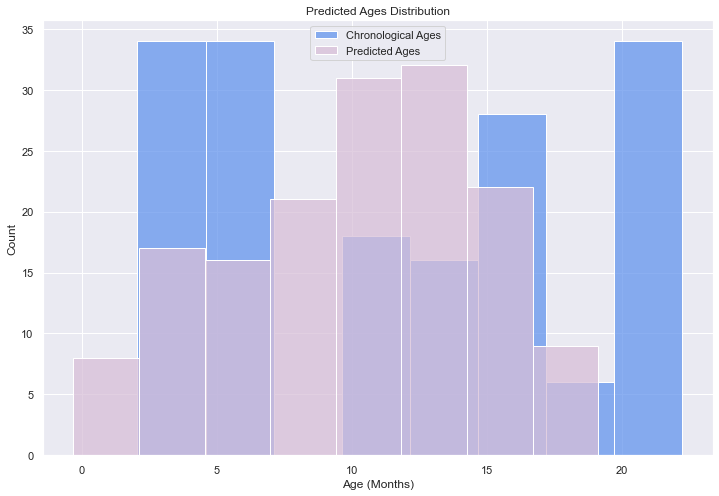

In [31]:
plt.figure(figsize=(12,8))
plt.title('Predicted Ages Distribution')
plt.xlabel('Age (Months)')
sns.set(style="darkgrid")
sns.histplot(data=metadata, x='age', color='cornflowerblue', label="Chronological Ages", bins=8)
sns.histplot(data=metadata, x='predicted_age', color="thistle", label="Predicted Ages", bins=8)
plt.legend()
plt.show()

# Delta Ages

In [7]:
# define delta age (predicted age - chronological age) and add to metadata
metadata["delta"] = metadata['predicted_age'] - metadata['age']

# extract columns of interest and drop rows with NaNs
metadata_nona = metadata[['age', 'predicted_age', 'tissue', 'Sex', 'delta', 'EarNotch', 'Color', 'DeathWeight', 'Cage', 'lab_id', 'sample_id']].dropna()

# export for use in other notebooks
metadata_nona.to_csv('../data/output/metadata_nona.csv', index=False)

In [8]:
metadata_nona

,age,predicted_age,tissue,Sex,delta,EarNotch,Color,DeathWeight,Cage,lab_id,sample_id
0,22.045627,12.912954,Kidney,Female,-9.132673,N,AG,35.1,1,204375590020_R01C02,1
1,22.045627,11.568242,Liver,Female,-10.477385,N,AG,35.1,1,204375590004_R01C02,1
2,22.045627,14.191182,Heart,Female,-7.854445,N,AG,35.1,1,204375590020_R01C01,1
3,22.045627,15.299708,L Gastroc,Female,-6.745919,N,AG,35.1,1,204375590004_R01C01,1
4,22.045627,14.440024,Kidney,Female,-7.605604,R,BAG,40.3,1,204375590025_R01C02,8
...,...,...,...,...,...,...,...,...,...,...,...
159,2.102713,4.572418,L Gastroc,Female,2.469706,N,BAG,21.1,14,204450040015_R04C01,316
160,2.102713,1.722923,Kidney,Female,-0.379789,N,BLK,20.2,14,204450040015_R05C02,323
161,2.102713,2.174054,Liver,Female,0.071341,N,BLK,20.2,14,204450040015_R06C02,323
162,2.102713,-0.302900,Heart,Female,-2.405613,N,BLK,20.2,14,204450040015_R05C01,323


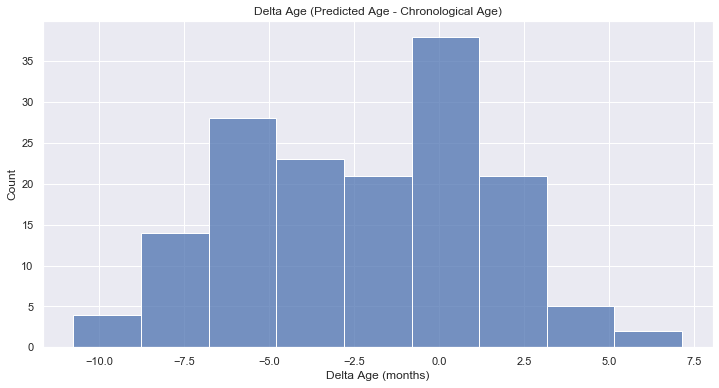

In [9]:
# visualize delta age
plt.figure(figsize=(12, 6))
plt.title('Delta Age (Predicted Age - Chronological Age)')
plt.xlabel('Delta Age (months)')
sns.histplot(x='delta',data=metadata_nona)

Mean Delta age for Heart: -2.7109040892487766
Mean Delta age for Liver: -3.0207383687147953
Mean Delta age for Kidney: -2.5955426890592412
Mean Delta age for L Gastroc: -0.46806657538791224


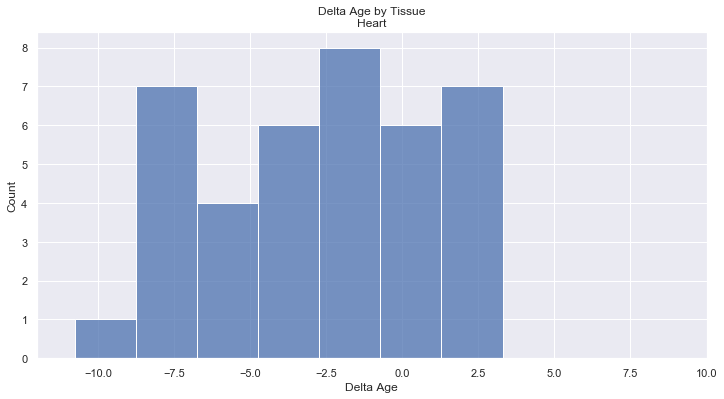

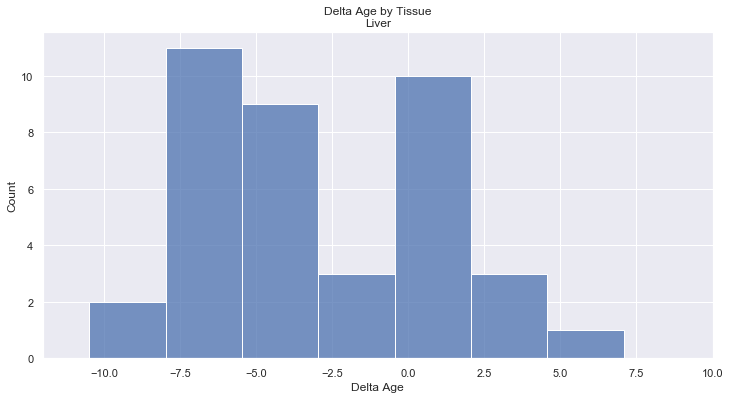

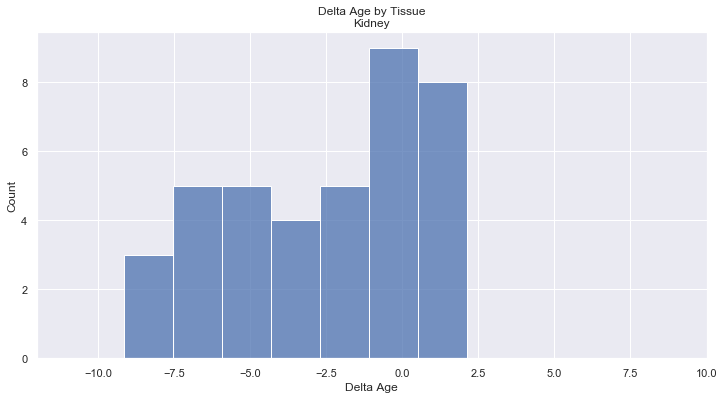

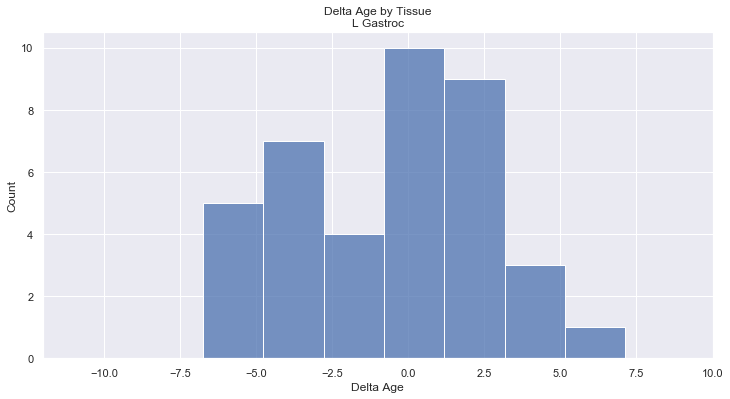

In [11]:
# visualize delta age by tissue type
for t in set(metadata_nona.tissue.values):
    plt.figure(figsize=(12, 6))
    plt.title('Delta Age by Tissue\n{}'.format(t))
    plt.xlim(-12, 10)
    plt.xlabel('Delta Age')
    sns.histplot(x='delta',data=metadata_nona[metadata_nona.tissue==t])
    print("Mean Delta age for " + str(t) + ": " + str(metadata_nona[metadata_nona.tissue==t]['delta'].mean()))

Mean Delta age for Male: -2.042316192235853
Mean Delta age for Female: -2.347484832051167


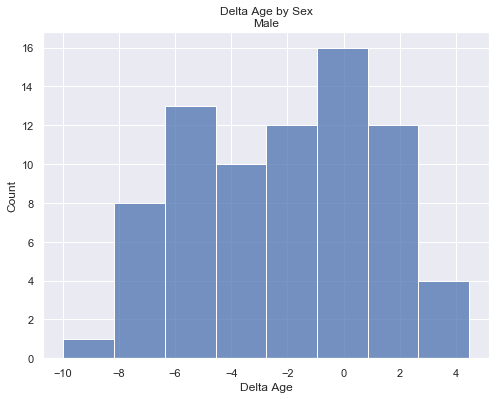

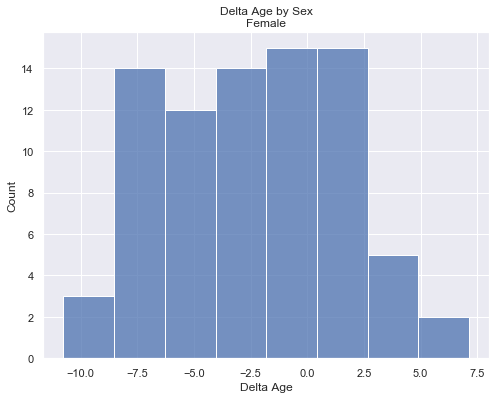

In [12]:
# delta age by sex
for t in set(metadata_nona.Sex.values):
    plt.figure(figsize=(8, 6))
    plt.title('Delta Age by Sex\n{}'.format(t))
    plt.xlabel('Delta Age')
    sns.histplot(x='delta',data=metadata_nona[metadata_nona.Sex==t])
    print("Mean Delta age for " + str(t) + ": " + str(metadata_nona[metadata_nona.Sex==t]['delta'].mean()))

# RMSE

In [13]:
# calculate RMSE with predicted age
y_true = metadata_nona['age']
y_pred = metadata_nona['predicted_age']

mean_squared_error(y_true, y_pred)

18.137380074264872

# Linear Regression on Combined Data

In [14]:
# Linear Regression (OLS) with all data
X = metadata_nona['age']
y = metadata_nona['predicted_age']

regr = stats.linregress(X, y)

print(f"R-squared: {regr.rvalue**2:.6f}")
print(f"Pearson's r: {regr.rvalue:.6f}")


R-squared: 0.768843
Pearson's r: 0.876837


# Visualizing Predicted Ages of Combined Data

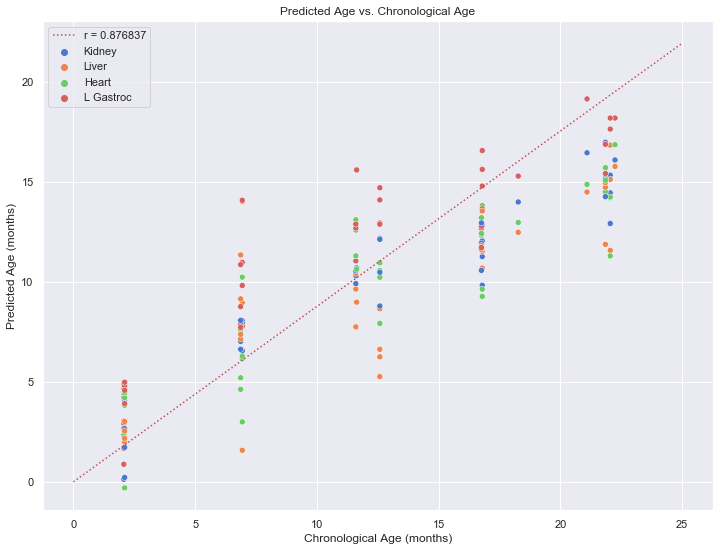

In [15]:
x = np.linspace(0,25,100)
y = x*regr.rvalue

fig, ax = plt.subplots(figsize=(12,9))
sns.scatterplot(data=metadata, x="age", y="predicted_age", hue="tissue", palette='muted')
plt.title("Predicted Age vs. Chronological Age")
plt.xlabel("Chronological Age (months)")
plt.ylabel("Predicted Age (months)")
plt.plot(x, y, 'r:', label="r = 0.876837")
plt.legend(loc="upper left")
plt.show()

# Visualizing Predicted Ages (Stratified by Tissue)

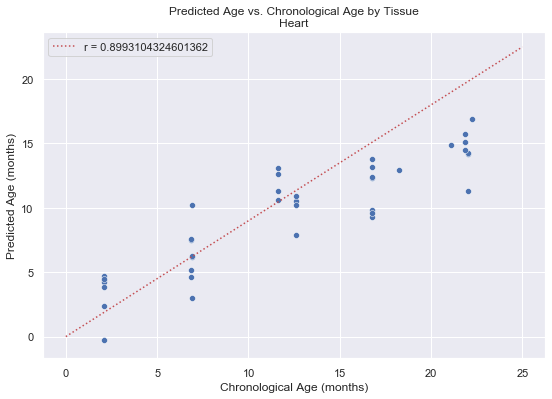

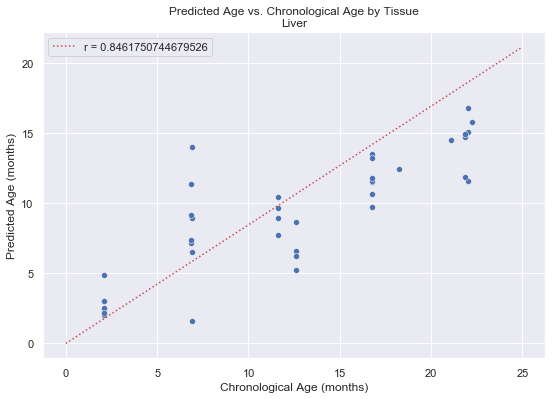

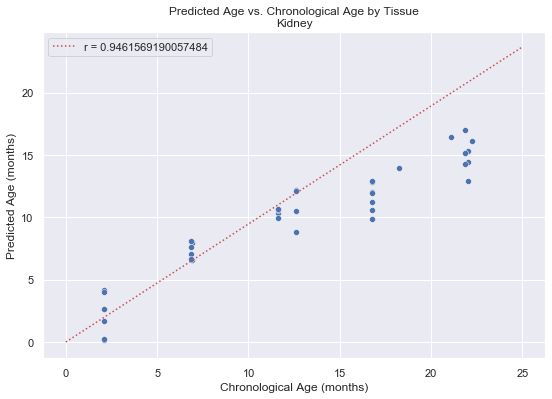

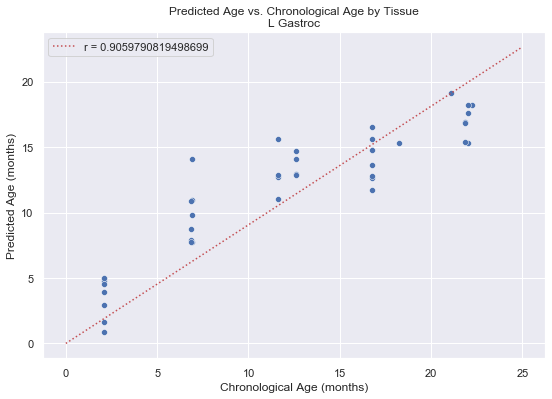

In [16]:
# Running Linear Regression on each set of tissues and then plotting them

for t in set(metadata_nona.tissue.values):
    # Linear Regression
    X = metadata_nona[metadata_nona.tissue==t]['age']
    y = metadata_nona[metadata_nona.tissue==t]['predicted_age']
    regr = stats.linregress(X, y)
    score = regr.rvalue

    # Visualizing Data
    plt.figure(figsize=(9,6))
    plt.title("Predicted Age vs. Chronological Age by Tissue\n{}".format(t))
    plt.xlabel("Chronological Age (months)")
    plt.ylabel("Predicted Age (months)")
    x = np.linspace(0,25,100)
    y = x*score
    plt.plot(x, y, 'r:', label=("r = " + str(score)))
    sns.scatterplot(data=metadata_nona[metadata_nona.tissue==t], x="age", y="predicted_age")


# Visualizing Predicted Ages (Stratified by Sex)

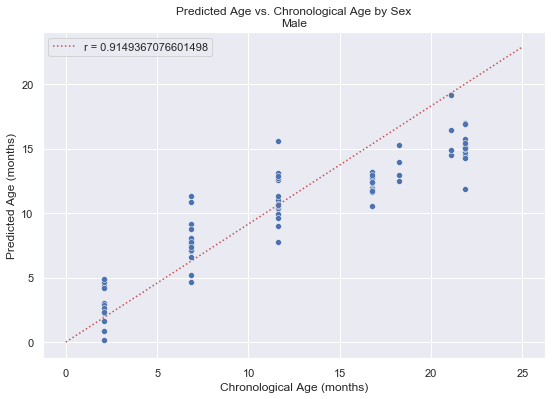

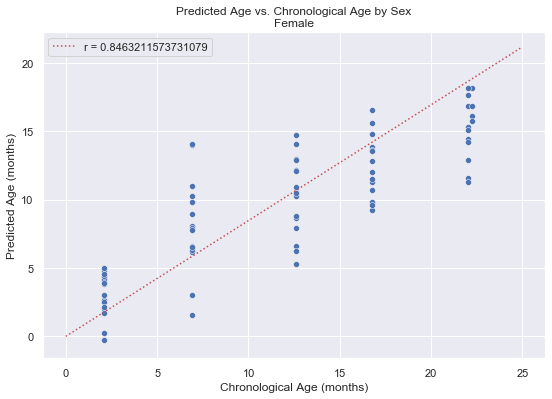

In [17]:
# Linear Regression on male/female subsets of data and plotting results

for t in set(metadata_nona.Sex.values):
    # Linear Regression
    X = metadata_nona[metadata_nona.Sex==t]['age']
    y = metadata_nona[metadata_nona.Sex==t]['predicted_age']
    regr = stats.linregress(X, y)
    score = regr.rvalue

    # Plot
    plt.figure(figsize=(9,6))
    plt.title("Predicted Age vs. Chronological Age by Sex\n{}".format(t))
    plt.xlabel("Chronological Age (months)")
    plt.ylabel("Predicted Age (months)")
    x = np.linspace(0,25,100)
    y = x*score
    plt.plot(x, y, 'r:', label=("r = " + str(score)))
    sns.scatterplot(data=metadata_nona[metadata_nona.Sex==t], x="age", y="predicted_age")

# Investigating statistical significance of Delta Ages between groups

In [18]:
# define dataframes for m/f mice
delta_ages_m = metadata_nona[metadata_nona['Sex'] == 'M']
delta_ages_f = metadata_nona[metadata_nona['Sex'] == 'F']

# ANOVA to test whether delta ages are significantly different between the two groups
stats.f_oneway(delta_ages_m['delta'], delta_ages_f['delta'])

/Users/patriciagirardi/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3621: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


F_onewayResult(statistic=nan, pvalue=nan)

In [19]:
# kruskal-wallis test for tissues (multi-group comparison)
delta_ages_h = metadata_nona[metadata_nona['tissue'] == 'Heart']
delta_ages_k = metadata_nona[metadata_nona['tissue'] == 'Kidney']
delta_ages_l = metadata_nona[metadata_nona['tissue'] == 'Liver']
delta_ages_g = metadata_nona[metadata_nona['tissue'] == 'L Gastroc']

stats.kruskal(delta_ages_h['delta'], delta_ages_k['delta'], delta_ages_l['delta'], delta_ages_g['delta'])

KruskalResult(statistic=12.238859784670638, pvalue=0.006608150755410611)

In [20]:
# there is significant difference from at least one of the groups
# ANOVA of group vs. the rest to test which group is significantly different

for t in set(metadata_nona.tissue.values):
    print(str(t) + " vs. other tissues:")
    no_t = metadata_nona.drop(metadata_nona[metadata_nona.tissue==t].index)
    print(str(stats.f_oneway(metadata_nona[metadata_nona.tissue==t]['delta'], no_t['delta'])) + "\n")

Heart vs. other tissues:
F_onewayResult(statistic=1.018639780308154, pvalue=0.31442502803051353)

Liver vs. other tissues:
F_onewayResult(statistic=2.651810074359753, pvalue=0.10547611181424667)

Kidney vs. other tissues:
F_onewayResult(statistic=0.6097736525911521, pvalue=0.4360717564343156)

L Gastroc vs. other tissues:
F_onewayResult(statistic=12.497300200509322, pvalue=0.0005385013759873986)



In [21]:
# Gastroc seems to be significantly different from the other tissues as a whole
# Let's see how gastroc differs from the other tissue groups individually

# Gastroc vs. Heart
print("Gastroc vs. Heart: " + str(stats.f_oneway(delta_ages_h['delta'], delta_ages_g['delta'])))

# Gastroc vs. Liver
print("Gastroc vs. Liver: " + str(stats.f_oneway(delta_ages_k['delta'], delta_ages_g['delta'])))

# Gastroc vs. Kidney
print("Gastroc vs. Kidney: " + str(stats.f_oneway(delta_ages_l['delta'], delta_ages_g['delta'])))


Gastroc vs. Heart: F_onewayResult(statistic=8.082877501627799, pvalue=0.005736240389664008)
Gastroc vs. Liver: F_onewayResult(statistic=8.567916282337817, pvalue=0.004511144128734942)
Gastroc vs. Kidney: F_onewayResult(statistic=9.283998671730298, pvalue=0.0031779415973058815)
